In [1]:
# Standardbibliotheken
import sys

# Drittanbieter Libs
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# eigene Module
sys.path.append("../src")
from utils import luminance, clustersize

In [2]:
# Beispielbild laden
img = Image.open("../assets/beispiel.jpg").convert("RGB")
pixels = np.array(img)

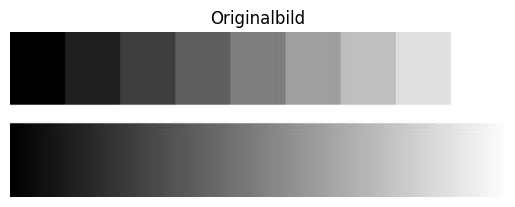

In [3]:
# Beispielbild anzeigen
plt.imshow(img)
plt.title("Originalbild")
plt.axis("off")
plt.show()

In [4]:
# Test Vergleich von Pixel (0, 0) mit Pixel (10, 10), pixels[a, b] ist der pixel an der Stelle a, b auf dem Beispiel-Bild
p1 = pixels[20, 30]
helligkeit = luminance(p1)
print(helligkeit)

33.0


In [5]:
# Bildhöhe und -weite auslesen
height, width = pixels.shape[:2]
print(height)
print(width)

90
270


In [6]:
# berechnent die Größe der Cluster, damit diese auch gleich verteilt sind und kein Rand entsteht
print(clustersize(7.25, height, width))

(12, 37, 7.5, 7.297297297297297)


# Pseudocode für Glyphenbestimmung:

```Glyphen_matrix ist Matrix mit cluster_y Höheneinträgen und cluster_x Breiteneinträgen  
Für alle 0 <= i < cluster_y, 0 <= j < cluster_x do:  
    Für alle i * cluster_height <= m < (i+1) * cluster_height, i*cluster_width <= n < (i+1)*cluster_width do:   
        pixels[i * cluster_height,j*cluster_width] bis pixels[(i+1)*cluster_height, (j+1) * cluster_width]:  
        helligkeiten_added = helligkeit_temp + luminance(pixels[m,n])  
    cluster_helligkeit_durchschnitt = helligkeiten_added/(cluster_height * cluster_width)  
    glyph_temp = getGlyph(cluster_helligkeit_durchschnitt)  
    Glyphen_matrix[i,j] = glyph_temp